
#**Objective**:
###**Develop an algorithm which will identify the artist when provided with a painting, with state of the art precision**



# **Data Importing**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import os
from tqdm import tqdm, tqdm_notebook
import random

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.applications import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.initializers import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from numpy.random import seed
seed(1)

np.random.seed(1)

In [ ]:
print(os.listdir("/content/drive/MyDrive/CA[1]"))

['artists.csv', 'resized', 'images']


In [ ]:
artists = pd.read_csv('/content/drive/MyDrive/CA[1]/artists.csv')
artists.shape

(50, 8)

Explanation:

This section of the code imports necessary Python libraries, including Pandas for data manipulation, NumPy for numerical operations, Matplotlib for data visualization, and various TensorFlow and Keras modules for deep learning.

It sets random seeds for reproducibility and prints the list of files in a directory, likely to check the contents of the project directory.

The code then loads artist data from a CSV file named 'artists.csv' located in a specific directory.

# **Data Processing**

In [ ]:
# Sort artists by number of paintings
artists = artists.sort_values(by=['paintings'], ascending=False)

# Create a dataframe with artists having more than 200 paintings
artists_top = artists[artists['paintings'] >= 200].reset_index()
artists_top = artists_top[['name', 'paintings']]
#artists_top['class_weight'] = max(artists_top.paintings)/artists_top.paintings
artists_top['class_weight'] = artists_top.paintings.sum() / (artists_top.shape[0] * artists_top.paintings)
artists_top

name  paintings  class_weight
0        Vincent van Gogh        877      0.445631
1             Edgar Degas        702      0.556721
2           Pablo Picasso        439      0.890246
3   Pierre-Auguste Renoir        336      1.163149
4          Albrecht Dürer        328      1.191519
5            Paul Gauguin        311      1.256650
6          Francisco Goya        291      1.343018
7               Rembrandt        262      1.491672
8           Alfred Sisley        259      1.508951
9                  Titian        255      1.532620
10           Marc Chagall        239      1.635223

In [ ]:
# Set class weights - assign higher weights to underrepresented classes
class_weights = artists_top['class_weight'].to_dict()
class_weights

{0: 0.44563076604125634,
 1: 0.5567210567210568,
 2: 0.8902464278318493,
 3: 1.1631493506493507,
 4: 1.1915188470066518,
 5: 1.2566501023092662,
 6: 1.3430178069353327,
 7: 1.491672449687717,
 8: 1.5089505089505089,
 9: 1.532620320855615,
 10: 1.6352225180677062}

In [ ]:
# There is some problem recognizing 'Albrecht_Dürer'
updated_name = "Albrecht_Dürer".replace("_", " ")
artists_top.iloc[4, 0] = updated_name

Explanation:

In this section, the artists' data is sorted by the number of paintings they have created in descending order.

A new DataFrame is created, including only those artists with more than or equal to 200 paintings.

Class weights are calculated to address class imbalance, ensuring that underrepresented classes receive higher weights during model training.

The artist name 'Albrecht_Dürer' is updated to address special characters in the name.

In [ ]:
# Explore images of top artists
images_dir = '/content/drive/MyDrive/CA[1]/images/images'
artists_dirs = os.listdir(images_dir)
artists_top_name = artists_top['name'].str.replace(' ', '_').values

# See if all directories exist
for name in artists_top_name:
    if os.path.exists(os.path.join(images_dir, name)):
        print("Found -->", os.path.join(images_dir, name))
    else:
        print("Did not find -->", os.path.join(images_dir, name))

Found --> /content/drive/MyDrive/CA[1]/images/images/Vincent_van_Gogh
Found --> /content/drive/MyDrive/CA[1]/images/images/Edgar_Degas
Found --> /content/drive/MyDrive/CA[1]/images/images/Pablo_Picasso
Found --> /content/drive/MyDrive/CA[1]/images/images/Pierre-Auguste_Renoir
Found --> /content/drive/MyDrive/CA[1]/images/images/Albrecht_Dürer
Found --> /content/drive/MyDrive/CA[1]/images/images/Paul_Gauguin
Found --> /content/drive/MyDrive/CA[1]/images/images/Francisco_Goya
Found --> /content/drive/MyDrive/CA[1]/images/images/Rembrandt
Found --> /content/drive/MyDrive/CA[1]/images/images/Alfred_Sisley
Found --> /content/drive/MyDrive/CA[1]/images/images/Titian
Found --> /content/drive/MyDrive/CA[1]/images/images/Marc_Chagall


Explanation:

This part of the code explores the directory structure where artist images are stored.

It checks if directories for each artist exist in the specified directory, providing feedback on whether each artist's directory is found or not.

# **Printing Few Random Paintings**

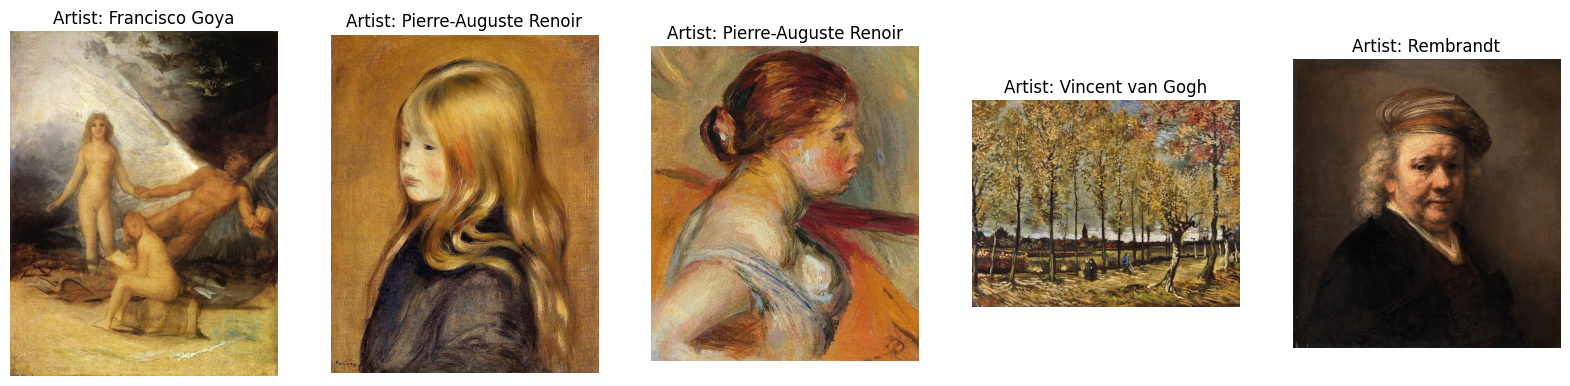

In [ ]:
# Print few random paintings
n = 5
fig, axes = plt.subplots(1, n, figsize=(20,10))

for i in range(n):
    random_artist = random.choice(artists_top_name)
    random_image = random.choice(os.listdir(os.path.join(images_dir, random_artist)))
    random_image_file = os.path.join(images_dir, random_artist, random_image)
    image = plt.imread(random_image_file)
    axes[i].imshow(image)
    axes[i].set_title("Artist: " + random_artist.replace('_', ' '))
    axes[i].axis('off')

plt.show()

Explanation:

This code segment displays a set of random paintings from different artists. It selects a random artist and a random image from their respective directories and displays them using Matplotlib.

In [ ]:
# Augment data
batch_size = 16
train_input_shape = (224, 224, 3)
n_classes = artists_top.shape[0]

train_datagen = ImageDataGenerator(validation_split=0.2,
                                   rescale=1./255.,
                                   #rotation_range=45,
                                   #width_shift_range=0.5,
                                   #height_shift_range=0.5,
                                   shear_range=5,
                                   #zoom_range=0.7,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                  )

train_generator = train_datagen.flow_from_directory(directory=images_dir,
                                                    class_mode='categorical',
                                                    target_size=train_input_shape[0:2],
                                                    batch_size=batch_size,
                                                    subset="training",
                                                    shuffle=True,
                                                    classes=artists_top_name.tolist()
                                                   )

valid_generator = train_datagen.flow_from_directory(directory=images_dir,
                                                    class_mode='categorical',
                                                    target_size=train_input_shape[0:2],
                                                    batch_size=batch_size,
                                                    subset="validation",
                                                    shuffle=True,
                                                    classes=artists_top_name.tolist()
                                                   )

STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n//valid_generator.batch_size
print("Total number of batches =", STEP_SIZE_TRAIN, "and", STEP_SIZE_VALID)

Found 3444 images belonging to 11 classes.
Found 855 images belonging to 11 classes.
Total number of batches = 215 and 53


Explanation:

This section defines data augmentation settings for the image data, including rescaling, shear range, and horizontal and vertical flips.

Data generators are created for training and validation using the specified data augmentation settings. These generators are responsible for feeding data to the model during training.

Step sizes for training and validation are calculated, which determine the number of batches used during training and validation.

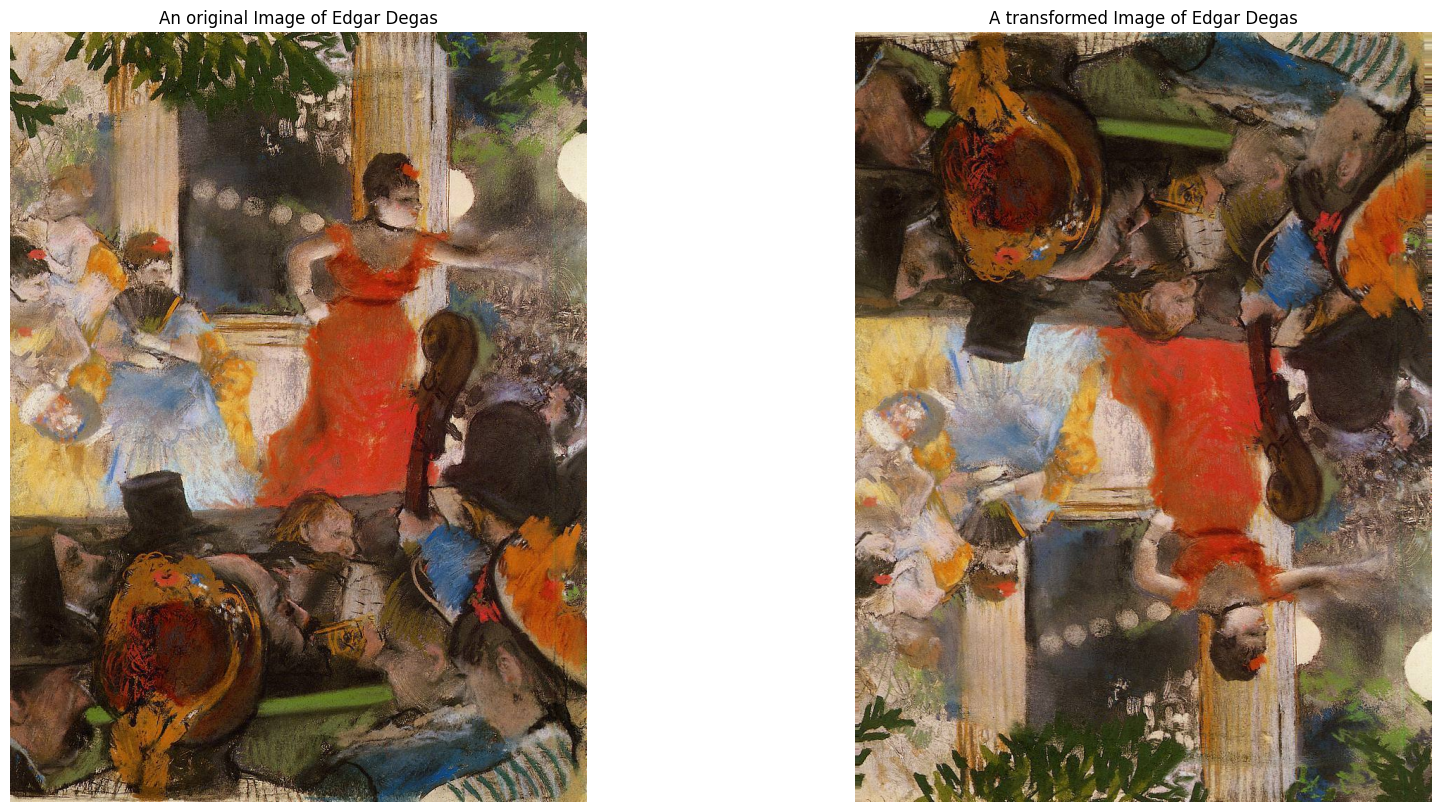

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

random_artist = random.choice(artists_top_name)
random_image = random.choice(os.listdir(os.path.join(images_dir, random_artist)))
random_image_file = os.path.join(images_dir, random_artist, random_image)

# Original image
image = plt.imread(random_image_file)
axes[0].imshow(image)
axes[0].set_title("An original Image of " + random_artist.replace('_', ' '))
axes[0].axis('off')

# Ensure the image has 3 channels (RGB)
if image.shape[-1] != 3:
    image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)

# Transformed image
aug_image = train_datagen.random_transform(image)
axes[1].imshow(aug_image)
axes[1].set_title("A transformed Image of " + random_artist.replace('_', ' '))
axes[1].axis('off')

plt.show()


# **Build Model**

In [ ]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=train_input_shape)

for layer in base_model.layers:
    layer.trainable = True

94765736/94765736 [==============================] - 1s 0us/step


In [ ]:
# Add layers at the end
X = base_model.output
X = Flatten()(X)

X = Dense(512, kernel_initializer='he_uniform')(X)
#X = Dropout(0.5)(X)
X = BatchNormalization()(X)
X = Activation('relu')(X)

X = Dense(16, kernel_initializer='he_uniform')(X)
#X = Dropout(0.5)(X)
X = BatchNormalization()(X)
X = Activation('relu')(X)

output = Dense(n_classes, activation='softmax')(X)

model = Model(inputs=base_model.input, outputs=output)

In [ ]:
optimizer = Adam(lr=0.0001)
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

In [ ]:
n_epoch = 10

early_stop = EarlyStopping(monitor='val_loss', patience=20, verbose=1,
                           mode='auto', restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5,
                              verbose=1, mode='auto')

In [ ]:
# Train the model - all layers
history1 = model.fit_generator(generator=train_generator, steps_per_epoch=STEP_SIZE_TRAIN,
                              validation_data=valid_generator, validation_steps=STEP_SIZE_VALID,
                              epochs=n_epoch,
                              shuffle=True,
                              verbose=1,
                              callbacks=[reduce_lr],
                              use_multiprocessing=True,
                              workers=16,
                              class_weight=class_weights
                             )

<ipython-input-15-907474c30487>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history1 = model.fit_generator(generator=train_generator, steps_per_epoch=STEP_SIZE_TRAIN,


Epoch 1/10
215/215 [==============================] - 209s 717ms/step - loss: 1.8808 - accuracy: 0.3512 - val_loss: 3.6408 - val_accuracy: 0.0613 - lr: 0.0010
Epoch 2/10
215/215 [==============================] - 114s 511ms/step - loss: 1.5730 - accuracy: 0.4542 - val_loss: 3.8879 - val_accuracy: 0.0613 - lr: 0.0010
Epoch 3/10
215/215 [==============================] - 126s 570ms/step - loss: 1.3960 - accuracy: 0.5020 - val_loss: 3.2156 - val_accuracy: 0.0625 - lr: 0.0010
Epoch 4/10
215/215 [==============================] - 113s 508ms/step - loss: 1.2524 - accuracy: 0.5519 - val_loss: 2.4959 - val_accuracy: 0.2017 - lr: 0.0010
Epoch 5/10
215/215 [==============================] - 127s 574ms/step - loss: 1.1825 - accuracy: 0.5770 - val_loss: 2.1420 - val_accuracy: 0.2960 - lr: 0.0010
Epoch 6/10
215/215 [==============================] - 114s 507ms/step - loss: 1.1042 - accuracy: 0.5846 - val_loss: 1.9479 - val_accuracy: 0.3703 - lr: 0.0010
Epoch 7/10
215/215 [==========================

In [ ]:


# Freeze core ResNet layers and train again
for layer in model.layers:
    layer.trainable = False

for layer in model.layers[:50]:
    layer.trainable = True

optimizer = Adam(lr=0.0001)

model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

n_epoch = 50
history2 = model.fit_generator(generator=train_generator, steps_per_epoch=STEP_SIZE_TRAIN,
                              validation_data=valid_generator, validation_steps=STEP_SIZE_VALID,
                              epochs=n_epoch,
                              shuffle=True,
                              verbose=1,
                              callbacks=[reduce_lr, early_stop],
                              use_multiprocessing=True,
                              workers=16,
                              class_weight=class_weights
                             )

<ipython-input-16-40e27b09da68>:15: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history2 = model.fit_generator(generator=train_generator, steps_per_epoch=STEP_SIZE_TRAIN,


Epoch 1/50
215/215 [==============================] - 123s 497ms/step - loss: 0.7296 - accuracy: 0.7194 - val_loss: 1.4888 - val_accuracy: 0.5094 - lr: 0.0010
Epoch 2/50
215/215 [==============================] - 111s 500ms/step - loss: 0.6280 - accuracy: 0.7500 - val_loss: 1.2537 - val_accuracy: 0.5943 - lr: 0.0010
Epoch 3/50
215/215 [==============================] - 125s 560ms/step - loss: 0.5906 - accuracy: 0.7660 - val_loss: 1.6817 - val_accuracy: 0.4870 - lr: 0.0010
Epoch 4/50
215/215 [==============================] - 110s 496ms/step - loss: 0.6088 - accuracy: 0.7631 - val_loss: 1.2200 - val_accuracy: 0.5755 - lr: 0.0010
Epoch 5/50
215/215 [==============================] - 111s 500ms/step - loss: 0.5599 - accuracy: 0.7806 - val_loss: 1.5347 - val_accuracy: 0.5236 - lr: 0.0010
Epoch 6/50
215/215 [==============================] - 112s 501ms/step - loss: 0.5568 - accuracy: 0.7818 - val_loss: 1.2909 - val_accuracy: 0.5814 - lr: 0.0010
Epoch 7/50
215/215 [==========================

Explanation:

This part of the code defines the base model, which is ResNet50, a popular deep learning model architecture, and builds a custom model on top of it.

Custom layers are added to the base model, including fully connected (Dense) layers, batch normalization, and activation functions.

The model is compiled with an Adam optimizer and categorical cross-entropy loss.

Training is divided into two phases. Initially, all layers are trained. Then, the core ResNet layers are frozen, and only the top layers are trained.

Callbacks for early stopping and learning rate reduction are defined to optimize the training process.

# **Training Graph**

In [ ]:
# Merge history1 and history2
history = {}
history['loss'] = history1.history['loss'] + history2.history['loss']
history['accuracy'] = history1.history['accuracy'] + history2.history['accuracy']
history['val_loss'] = history1.history['val_loss'] + history2.history['val_loss']
history['val_accuracy'] = history1.history['val_accuracy'] + history2.history['val_accuracy']
history['lr'] = history1.history['lr'] + history2.history['lr']


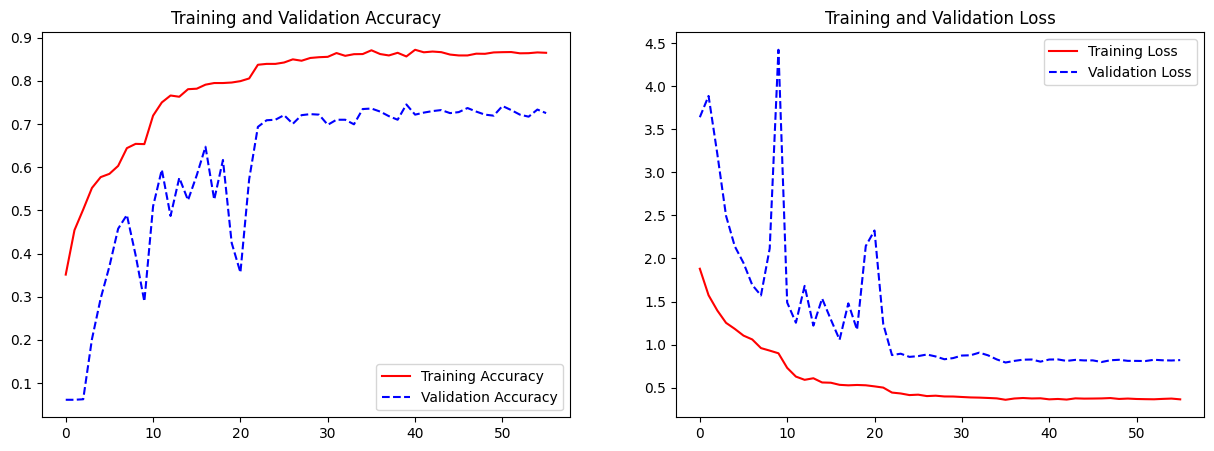

In [ ]:
# Plot the training graph
def plot_training(history):
    accuracy = history['accuracy']
    val_accuracy = history['val_accuracy']
    loss = history['loss']
    val_loss = history['val_loss']
    epochs = range(len(accuracy))

    fig, axes = plt.subplots(1, 2, figsize=(15,5))

    axes[0].plot(epochs, accuracy, 'r-', label='Training Accuracy')
    axes[0].plot(epochs, val_accuracy, 'b--', label='Validation Accuracy')
    axes[0].set_title('Training and Validation Accuracy')
    axes[0].legend(loc='best')

    axes[1].plot(epochs, loss, 'r-', label='Training Loss')
    axes[1].plot(epochs, val_loss, 'b--', label='Validation Loss')
    axes[1].set_title('Training and Validation Loss')
    axes[1].legend(loc='best')

    plt.show()

plot_training(history)

Explanation:

The training history from both training phases is merged into a single history dictionary.

A function plot_training is defined to visualize the training and validation accuracy and loss over epochs using Matplotlib.

# **Evaluate Performance**

In [ ]:
# Prediction accuracy on train data
score = model.evaluate_generator(train_generator, verbose=1)
print("Prediction accuracy on train data =", score[1])

<ipython-input-19-1dfa5047d603>:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  score = model.evaluate_generator(train_generator, verbose=1)


216/216 [==============================] - 81s 374ms/step - loss: 0.4183 - accuracy: 0.8772
Prediction accuracy on train data = 0.8771777153015137


In [ ]:
# Prediction accuracy on CV data
score = model.evaluate_generator(valid_generator, verbose=1)
print("Prediction accuracy on CV data =", score[1])

<ipython-input-20-d4a6d1ee285c>:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  score = model.evaluate_generator(valid_generator, verbose=1)


54/54 [==============================] - 20s 372ms/step - loss: 0.8047 - accuracy: 0.7263
Prediction accuracy on CV data = 0.7263157963752747


Explanation:

The code evaluates the model's performance on training and validation data using the evaluate_generator method.

The prediction accuracy on both training and cross-validation (CV) data is calculated and printed.

# **Confusion Matrix**

1/1 [==============================] - 0s 39ms/step


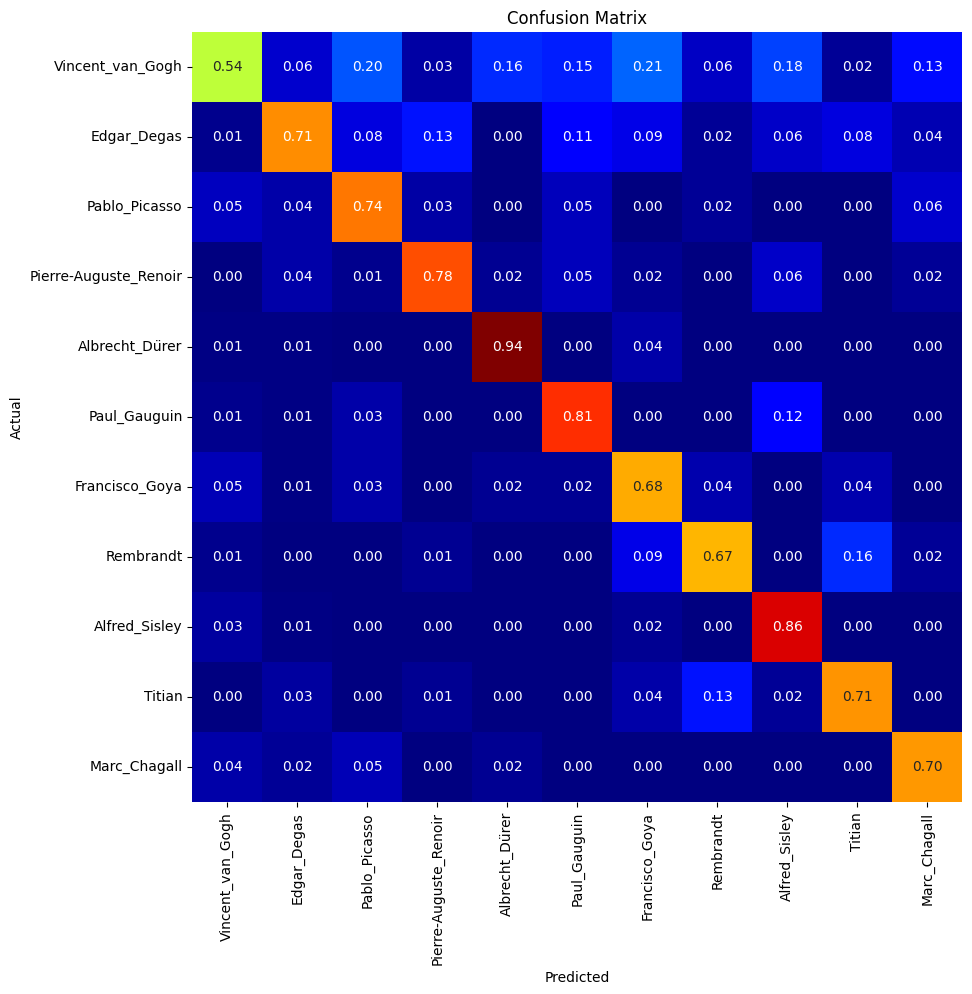

Classification Report:
                       precision    recall  f1-score   support

     Vincent_van_Gogh       0.73      0.54      0.62       171
          Edgar_Degas       0.77      0.71      0.74       139
        Pablo_Picasso       0.65      0.74      0.69        87
Pierre-Auguste_Renoir       0.78      0.78      0.78        67
      Albrecht_Dürer       0.82      0.94      0.88        64
         Paul_Gauguin       0.68      0.81      0.74        62
       Francisco_Goya       0.58      0.68      0.63        57
            Rembrandt       0.71      0.67      0.69        52
        Alfred_Sisley       0.67      0.86      0.75        51
               Titian       0.71      0.71      0.71        51
         Marc_Chagall       0.72      0.70      0.71        47

             accuracy                           0.71       848
            macro avg       0.71      0.74      0.72       848
         weighted avg       0.72      0.71      0.71       848



In [ ]:
# Classification report and confusion matrix
from sklearn.metrics import *
import seaborn as sns

tick_labels = artists_top_name.tolist()

def showClassficationReport_Generator(model, valid_generator, STEP_SIZE_VALID):
    # Loop on each generator batch and predict
    y_pred, y_true = [], []
    for i in range(STEP_SIZE_VALID):
        (X,y) = next(valid_generator)
        y_pred.append(model.predict(X))
        y_true.append(y)

    # Create a flat list for y_true and y_pred
    y_pred = [subresult for result in y_pred for subresult in result]
    y_true = [subresult for result in y_true for subresult in result]

    # Update Truth vector based on argmax
    y_true = np.argmax(y_true, axis=1)
    y_true = np.asarray(y_true).ravel()

    # Update Prediction vector based on argmax
    y_pred = np.argmax(y_pred, axis=1)
    y_pred = np.asarray(y_pred).ravel()

    # Confusion Matrix
    fig, ax = plt.subplots(figsize=(10,10))
    conf_matrix = confusion_matrix(y_true, y_pred, labels=np.arange(n_classes))
    conf_matrix = conf_matrix/np.sum(conf_matrix, axis=1)
    sns.heatmap(conf_matrix, annot=True, fmt=".2f", square=True, cbar=False,
                cmap=plt.cm.jet, xticklabels=tick_labels, yticklabels=tick_labels,
                ax=ax)
    ax.set_ylabel('Actual')
    ax.set_xlabel('Predicted')
    ax.set_title('Confusion Matrix')
    plt.show()

    print('Classification Report:')
    print(classification_report(y_true, y_pred, labels=np.arange(n_classes), target_names=artists_top_name.tolist()))

showClassficationReport_Generator(model, valid_generator, STEP_SIZE_VALID)

# *Evaluate performance by predicting on random images from dataset*

1/1 [==============================] - 0s 23ms/step


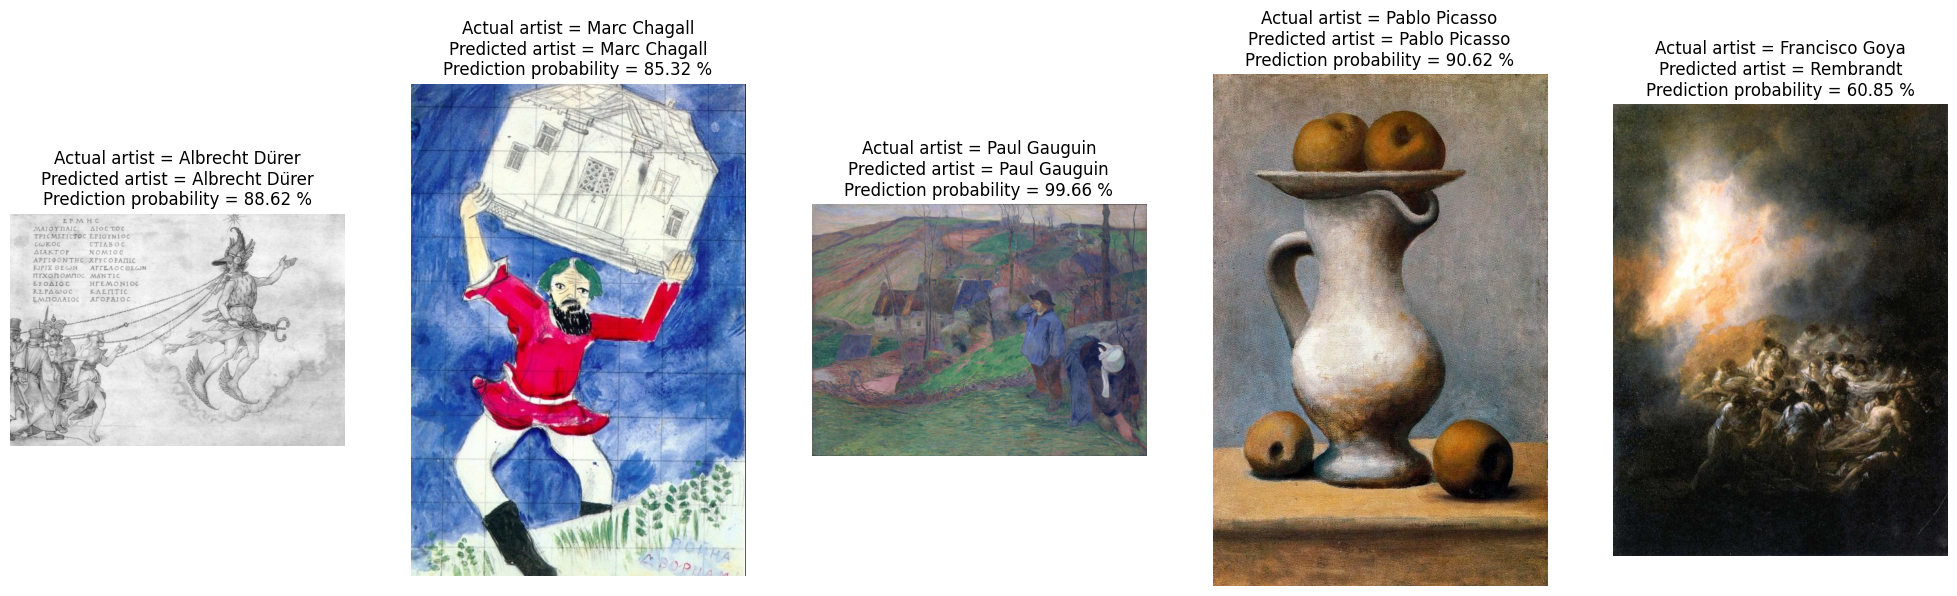

In [ ]:
from keras.preprocessing import *

n = 5
fig, axes = plt.subplots(1, n, figsize=(25,10))

for i in range(n):
    random_artist = random.choice(artists_top_name)
    random_image = random.choice(os.listdir(os.path.join(images_dir, random_artist)))
    random_image_file = os.path.join(images_dir, random_artist, random_image)

    # Original image

    test_image = image.load_img(random_image_file, target_size=(train_input_shape[0:2]))

    # Predict artist
    test_image = image.img_to_array(test_image)
    test_image /= 255.
    test_image = np.expand_dims(test_image, axis=0)

    prediction = model.predict(test_image)
    prediction_probability = np.amax(prediction)
    prediction_idx = np.argmax(prediction)

    labels = train_generator.class_indices
    labels = dict((v,k) for k,v in labels.items())

    #print("Actual artist =", random_artist.replace('_', ' '))
    #print("Predicted artist =", labels[prediction_idx].replace('_', ' '))
    #print("Prediction probability =", prediction_probability*100, "%")

    title = "Actual artist = {}\nPredicted artist = {}\nPrediction probability = {:.2f} %" \
                .format(random_artist.replace('_', ' '), labels[prediction_idx].replace('_', ' '),
                        prediction_probability*100)

    # Print image
    axes[i].imshow(plt.imread(random_image_file))
    axes[i].set_title(title)
    axes[i].axis('off')

plt.show()

Explanation:

This code defines a function showClassficationReport_Generator to evaluate the model's performance using a classification report and a confusion matrix.

The function makes predictions on the validation data by looping through each batch of the valid_generator.

It calculates the classification report using the classification_report function from the sklearn.metrics library, which provides metrics such as precision, recall, F1-score, and support for each class.

It also calculates the confusion matrix using the confusion_matrix function and normalizes it by dividing each row by its sum. The normalized confusion matrix is displayed as a heatmap using the seaborn library.

The classification report and confusion matrix are displayed to provide a comprehensive evaluation of the model's performance on the validation data. This information is crucial for assessing how well the model can classify artists based on their paintings.